In [28]:
import torch
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import time
from tqdm import tqdm

In [29]:
color_map = {
    (0, 0, 0) : 0, #Background
    (74,222,128) : 1, #Forb
    (96,165,250) : 2, #Short Graminoid
    (29,78,216) : 2, #Tall Graminoid
    (221,255,51) : 3, #Woody
    (220,38,38) : 0, #Litter 
}

In [30]:
name_map = {
    (0, 0, 0) : "Background", #Background
    (74,222,128) : "Forb", #Forb
    (96,165,250) : "Gramminoid", #Short Graminoid
    (221,255,51) : "Woody", #Woody
}

In [31]:
class VegetationDataset(Dataset):
    def __init__(self, root_dir, tranform=None, patch_size=1024, overlap = 204):
        """Simple dataset for vegetation segmentation test."""
        self.samples = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                image_path = os.path.join(folder_path, f"{folder}.jpg")
                mask_path = os.path.join(folder_path, f"{folder}_mask.png")
                if os.path.exists(image_path) and os.path.exists(mask_path):
                    self.samples.append((image_path, mask_path))
        self.transform = tranform
        self.patch_size = patch_size
        self.overlap = overlap
    
    def __len__(self):
        return len(self.samples)
    
    def __rgb_to_class_mask(self, rgb_mask):
        """Convert the RGB mask to grayscale class mask."""
        height, width = rgb_mask.shape[:2]
        class_mask = np.zeros((height, width), dtype=np.uint8)

        for rgb, class_index in color_map.items():
            match = np.all(rgb_mask == rgb, axis=2)
            class_mask[match] = class_index
        return class_mask
    
    def __extract_patches(self, image, mask):
        """
        Create 512 by 512 patches for more effectient training.
        
        Args: image and mask numpy arrays with shape (H, W, 3) and (H,W) respectively
        """
        patches = []
        step = self.patch_size - self.overlap
        h, w, _ = image.shape
        for y in range(0, h - self.patch_size + 1, step):
            for x in range(0, w- self.patch_size + 1, step):
                image_patch = image[y:y+self.patch_size, x:x+self.patch_size, :]
                mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
                patches.append((image_patch, mask_patch))
        return patches
    
    def __getitem__(self, idx):
        # Load image and mask
        
        image_path, mask_path = self.samples[idx]
        image = Image.open(image_path).convert('RGB')


        mask = Image.open(mask_path).convert('RGB')

        if mask.size != image.size:
            # Rotate mask by 90° if needed (this assumes the mask is rotated)
            mask = mask.transpose(Image.ROTATE_90)
        
        mask = np.array(mask)
        mask = self.__rgb_to_class_mask(mask)
        image_np = np.array(image)

        #Get the patches array
        patches = self.__extract_patches(image_np, mask)

        #apply transforms and convert to tensor
        patch_tuples = []
        for image_patch, mask_patch in patches:
            pil_patch = Image.fromarray(image_patch)
            if self.transform:
                pil_patch = self.transform(pil_patch)
            mask_tensor = torch.tensor(mask_patch, dtype=torch.long)
            patch_tuples.append((pil_patch, mask_tensor))

        return patch_tuples

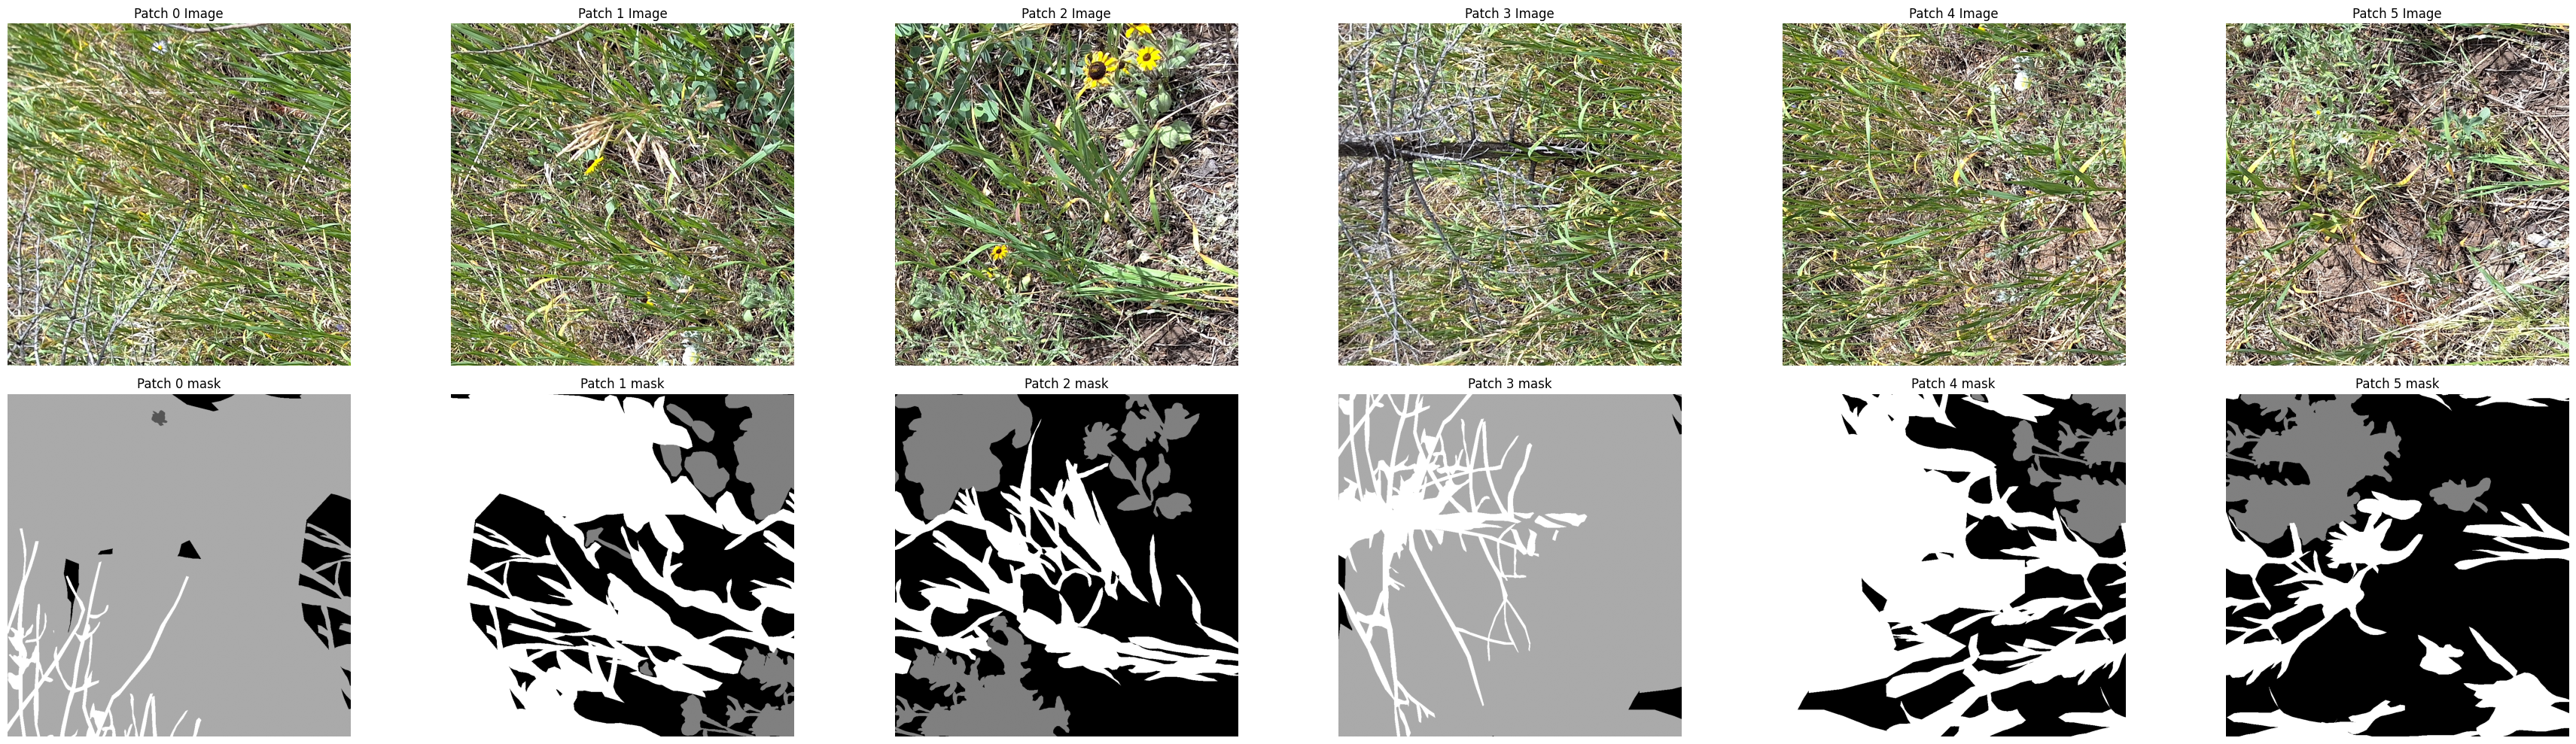

In [5]:
def show_dataset_sample(dataset, idx = 0):
    patch_tuples = dataset[idx]
    num_patches = len(patch_tuples)

    fig, axes = plt.subplots(2, num_patches, figsize=(6*num_patches, 10))
    for i, (img_patch, mask_tensor) in enumerate(patch_tuples):
        if isinstance(img_patch, torch.Tensor):
            img_patch = img_patch.permute(1,2,0).cpu().numpy()
        axes[0,i].imshow(img_patch)
        axes[0,i].set_title(f'Patch {i} Image')
        axes[0,i].axis('off')

        if isinstance(mask_tensor, torch.Tensor):
            mask_np = mask_tensor.cpu().numpy()
        else:
            mask_np = mask_tensor
        axes[1,i].imshow(mask_np, cmap='gray')
        axes[1,i].set_title(f'Patch {i} mask')
        axes[1,i].axis('off')
    plt.tight_layout()
    plt.show()

dir = "/home/nels/TeamVida/Tick Dataset"
#Image_path = "TestImage.jpg"
#Mask_path = "TestImageMask.png"
dataset = VegetationDataset(root_dir=dir, tranform=None)
show_dataset_sample(dataset, idx=50)

In [32]:
from collections import OrderedDict, defaultdict
from torchvision.io import read_image  # returns torch.Tensor [C,H,W], uint8
import torchvision.transforms.v2 as T
from dataclasses import dataclass

@dataclass
class SampleMeta:
    img_path: str
    mask_path: str
    W: int
    H: int

class _LRU:
    def __init__(self, capacity: int):
        self.cap = capacity
        self._d = OrderedDict()
    def get(self, k):
        v = self._d.get(k)
        if v is not None:
            self._d.move_to_end(k)
        return v
    def set(self, k, v):
        self._d[k] = v
        self._d.move_to_end(k)
        if len(self._d) > self.cap:
            self._d.popitem(last=False)

def build_dense_lut(color_map: dict):
    # default class 0 for any unknown color
    lut = np.zeros((256, 256, 256), dtype=np.uint8)
    for (r, g, b), cls in color_map.items():
        lut[r, g, b] = np.uint8(cls)
    return lut

def rgb_to_classes_dense(mask_rgb_chw: torch.Tensor, dense_lut: np.ndarray) -> torch.Tensor:
    # mask_rgb_chw: uint8 [3,H,W]
    m = mask_rgb_chw.permute(1,2,0).contiguous().cpu().numpy()  # [H,W,3]
    cls = dense_lut[m[...,0], m[...,1], m[...,2]]               # [H,W] uint8
    return torch.from_numpy(cls)



In [42]:
class PatchDataset(Dataset):
    """
    Expects a VegetationDataset or a torch.utils.data.Subset of it.
    Emits (img_uint8[3,H,W], msk_long[H,W], image_id) per patch.
    No normalization; do that in the training loop.
    """
    def __init__(
        self,
        image_ds_or_subset,         # Dataset or Subset that has .samples = [(img_path, mask_path), ...]
        color_map: dict,
        patch_size: int = 512,
        overlap: int = 100,
        cache_capacity: int = 16,
        rotate_mask_if_swapped: bool = True
    ):
        self.patch_size = patch_size
        self.step = patch_size - overlap
        self.rotate_mask_if_swapped = rotate_mask_if_swapped

        # Unwrap Subset if needed
        if hasattr(image_ds_or_subset, 'dataset') and hasattr(image_ds_or_subset, 'indices'):
            base_ds = image_ds_or_subset.dataset
            indices = list(image_ds_or_subset.indices)
        else:
            base_ds = image_ds_or_subset
            indices = list(range(len(base_ds)))

        # Expect base_ds.samples like your VegetationDataset
        if not hasattr(base_ds, "samples"):
            raise TypeError("Base dataset must expose `.samples = [(img_path, mask_path), ...]`")

        # Build SampleMeta for selected indices
        samples_meta = []
        for i in indices:
            img_path, mask_path = base_ds.samples[i]
            with Image.open(img_path) as im:
                W, H = im.size
            samples_meta.append(SampleMeta(img_path, mask_path, W, H))
        self.samples = samples_meta            # indexed by local image_id (0..n_images-1)
        self.image_ids = list(range(len(self.samples)))

        # Color LUT for masks
        self.dense_lut = build_dense_lut(color_map)

        # Precompute patch coords and grouping
        self.index = []  # (image_id, y, x)
        self.grouped_patch_indices = defaultdict(list)  # image_id -> [global_patch_idx]
        ps = self.patch_size
        for img_id, s in enumerate(self.samples):
            for y in range(0, s.H - ps + 1, self.step):
                for x in range(0, s.W - ps + 1, self.step):
                    self.grouped_patch_indices[img_id].append(len(self.index))
                    self.index.append((img_id, y, x))

        if not self.index:
            raise RuntimeError("No patches generated—check patch_size/overlap vs image sizes.")

        # Small caches for decoded tensors
        self._img_cache  = _LRU(cache_capacity)
        self._mask_cache = _LRU(cache_capacity)

    def __len__(self):
        return len(self.index)

    def _load_image_uint8_chw(self, path: str) -> torch.Tensor:
        t = self._img_cache.get(path)
        if t is None:
            t = read_image(path)  # uint8 [C,H,W]
            if t.ndim != 3 or t.shape[0] != 3:
                raise RuntimeError(f"Expected 3-channel image at {path}, got {tuple(t.shape)}")
            self._img_cache.set(path, t)
        return t

    def _load_mask_classes(self, meta: SampleMeta) -> torch.Tensor:
        t = self._mask_cache.get(meta.mask_path)
        if t is None:
            mask_rgb = read_image(meta.mask_path)  # uint8 [C,H,W]
            if mask_rgb.ndim != 3 or mask_rgb.shape[0] != 3:
                raise RuntimeError(f"Expected 3-channel mask at {meta.mask_path}, got {tuple(mask_rgb.shape)}")
            Hm, Wm = mask_rgb.shape[1], mask_rgb.shape[2]
            if self.rotate_mask_if_swapped and (Hm, Wm) != (meta.H, meta.W) and (Wm, Hm) == (meta.H, meta.W):
                mask_rgb = torch.rot90(mask_rgb, k=1, dims=(1,2))
                Hm, Wm = mask_rgb.shape[1], mask_rgb.shape[2]
            if (Hm, Wm) != (meta.H, meta.W):
                raise RuntimeError(f"Mask size {Hm}x{Wm} != image size {meta.H}x{meta.W}\n  {meta.mask_path}")
            t = rgb_to_classes_dense(mask_rgb, self.dense_lut).to(torch.uint8)  # uint8 [H,W]
            self._mask_cache.set(meta.mask_path, t)
        return t

    def __getitem__(self, idx):
        image_id, y, x = self.index[idx]
        meta = self.samples[image_id]

        img = self._load_image_uint8_chw(meta.img_path)  # uint8 [3,H,W]
        msk = self._load_mask_classes(meta)              # uint8 [H,W]

        ps = self.patch_size
        img_patch = img[:, y:y+ps, x:x+ps].contiguous()
        msk_patch = msk[y:y+ps, x:x+ps].contiguous().to(torch.long)  # cast here

        if img_patch.shape[1:] != (ps, ps) or msk_patch.shape != (ps, ps):
            raise RuntimeError(f"Bad patch idx={idx} from {meta.img_path}")

        # return image_id to enable grouping/aggregation
        return img_patch, msk_patch, image_id

In [7]:
def visualize_patches(dataset, color_map, num_samples=3, seed=0):
    """
    Display a few image/mask pairs from PatchDataset.
    
    Args:
        dataset: instance of PatchDataset
        color_map: dict { (R,G,B): class_index }
        num_samples: how many random patches to show
        seed: random seed for reproducibility
    """
    rng = np.random.default_rng(seed)

    # Build reverse LUT: class_idx -> RGB color
    max_cls = max(color_map.values())
    class_to_rgb = np.zeros((max_cls+1, 3), dtype=np.uint8)
    for rgb, cls in color_map.items():
        class_to_rgb[cls] = np.array(rgb, dtype=np.uint8)

    # Pick random indices
    idxs = rng.choice(len(dataset), size=num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 2, figsize=(6, 3*num_samples))
    if num_samples == 1:
        axes = [axes]  # make iterable

    for ax_row, idx in zip(axes, idxs):
        img_patch, mask_patch, _ = dataset[idx]  # img uint8 [3,H,W], mask long [H,W]

        # Convert image to HWC for matplotlib
        img_np = img_patch.permute(1,2,0).cpu().numpy()

        # Convert mask indices -> RGB
        mask_np = class_to_rgb[mask_patch.cpu().numpy()]

        ax_row[0].imshow(img_np)
        ax_row[0].set_title(f"Image patch idx={idx}")
        ax_row[0].axis("off")

        ax_row[1].imshow(mask_np)
        ax_row[1].set_title("Mask (colored)")
        ax_row[1].axis("off")

    plt.tight_layout()
    plt.show()

In [34]:
def pixel_accuracy(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        valid = (target >= 0)
        correct = (pred == target) * valid
        acc = correct.sum().float() / valid.sum().float()
    return acc.item()


In [35]:
def intersection_and_union(pred_or_logits, target, num_classes, eps=1e-6):
    """
    Computes per-class intersection and union.
    Accepts either:
      - logits: [B, C, H, W]  -> will argmax on C
      - preds:  [B, H, W]     -> used directly
    target must be [B, H, W] with class indices.
    """
    with torch.no_grad():
        if pred_or_logits.dim() == 4:
            # logits -> class indices
            pred = pred_or_logits.argmax(dim=1)
        elif pred_or_logits.dim() == 3:
            # already class indices
            pred = pred_or_logits
        else:
            raise ValueError(f"Unexpected pred_or_logits shape: {pred_or_logits.shape}")

        # Flatten
        pred_flat   = pred.reshape(-1)
        target_flat = target.reshape(-1)

        # Allocate on the right device/dtype
        device = pred_or_logits.device if torch.is_tensor(pred_or_logits) else pred.device
        intersection = torch.zeros(num_classes, device=device, dtype=torch.float32)
        union        = torch.zeros(num_classes, device=device, dtype=torch.float32)

        for cls in range(num_classes):
            p = (pred_flat == cls)
            t = (target_flat == cls)
            inter = (p & t).sum().float()
            uni   = (p | t).sum().float()
            intersection[cls] = inter
            union[cls] = uni

        iou = (intersection + eps) / (union + eps)
        return intersection, union, iou


In [36]:

def train_unet(model, dataloader, optimizer, criterion, device, num_classes=4,
               scaler=None, amp_dtype=torch.float16, amp_enabled=True):
    model.train()

    if (not hasattr(train_unet, "_norm_buffers") 
        or train_unet._norm_buffers[0].device != device):
        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
        train_unet._norm_buffers = (mean, std)
    mean, std = train_unet._norm_buffers

    if amp_enabled and scaler is None and torch.cuda.is_available():
        scaler = GradScaler()

    running_loss = 0.0
    running_acc = 0.0
    total_pixels = 0
    total_intersection = torch.zeros(num_classes, device=device)
    total_union = torch.zeros(num_classes, device=device)

    for images, masks, _ in tqdm(dataloader, desc="Training"):
        # images: uint8 [B,3,H,W] from dataset
        # Single hop: device + dtype + memory_format + non_blocking
        images = images.to(device=device,
                           dtype=torch.float32,
                           non_blocking=True,
                           memory_format=torch.channels_last)
        # Normalize on GPU
        images.mul_(1/255.0).sub_(mean).div_(std)
        masks = masks.to(device, non_blocking=True).long()
        

        optimizer.zero_grad(set_to_none=True)

        with autocast(dtype=amp_dtype, enabled=amp_enabled):
            outputs = model(images)                           # [B,C,H,W]
            loss = criterion(outputs, masks)

        if scaler is not None and amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
       

        B = images.size(0)
        running_loss += loss.item() * B

        preds = outputs.argmax(dim=1)                         # [B,H,W]
        running_acc += (preds == masks).sum().item()
        total_pixels += masks.numel()

        intersection, union, _ = intersection_and_union(preds, masks, num_classes)
        total_intersection += intersection
        total_union += union

    avg_loss = running_loss / len(dataloader.dataset)
    avg_acc  = (running_acc / total_pixels) * 100.0
    iou_per_class = (total_intersection / (total_union + 1e-6)).detach().cpu().numpy()
    mean_iou = float(iou_per_class.mean())
    return avg_loss, avg_acc, mean_iou, iou_per_class


In [60]:
@torch.no_grad()
def validate_unet(model, dataloader, criterion, device, num_classes=4,
                  amp_dtype=torch.float16, amp_enabled=True):
    model.eval()
    if not hasattr(train_unet, "_norm_buffers"):
        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
        train_unet._norm_buffers = (mean, std)
    mean, std = train_unet._norm_buffers

    running_loss = 0.0
    running_acc = 0.0
    total_pixels = 0
    total_intersection = torch.zeros(num_classes, device=device)
    total_union = torch.zeros(num_classes, device=device)

    for images, masks,_ in tqdm(dataloader, desc="Validating"):
        images = images.to(device, non_blocking=True).float().mul_(1/255.0)
        images = images.sub(mean).div(std)
        images = images.to(memory_format=torch.channels_last)
        masks  = masks.to(device, non_blocking=True).long()

        with autocast(dtype=amp_dtype, enabled=amp_enabled):
            outputs = model(images)
            loss = criterion(outputs, masks)

        B = images.size(0)
        running_loss += loss.item() * B
        preds = outputs.argmax(dim=1)
        running_acc += (preds == masks).sum().item()
        total_pixels += masks.numel()

        intersection, union, _ = intersection_and_union(preds, masks, num_classes)
        total_intersection += intersection
        total_union += union

    avg_loss = running_loss / len(dataloader.dataset)
    avg_acc  = (running_acc / total_pixels) * 100.0
    iou_per_class = (total_intersection / (total_union + 1e-6)).detach().cpu().numpy()
    mean_iou = float(iou_per_class.mean())
    return avg_loss, avg_acc, mean_iou, iou_per_class


In [38]:
import segmentation_models_pytorch as smp

unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=4
)

In [39]:
imgnet_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [44]:
from torch.utils.data import random_split

def create_train_val_datasets(full_dataset, val_ratio=0.2, seed=42):
    dataset_len = len(full_dataset)
    val_len = int(dataset_len * val_ratio)
    train_len = dataset_len - val_len
    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len], generator=generator)
    return train_dataset, val_dataset

full_dataset = VegetationDataset(root_dir="/home/nels/TeamVida/Tick Dataset", patch_size=512, overlap=100, tranform=None)
train_dataset, val_dataset = create_train_val_datasets(full_dataset, val_ratio=0.2)
train_patches = PatchDataset(train_dataset, color_map=color_map, cache_capacity=2)
val_patches   = PatchDataset(val_dataset, color_map=color_map, cache_capacity=2)

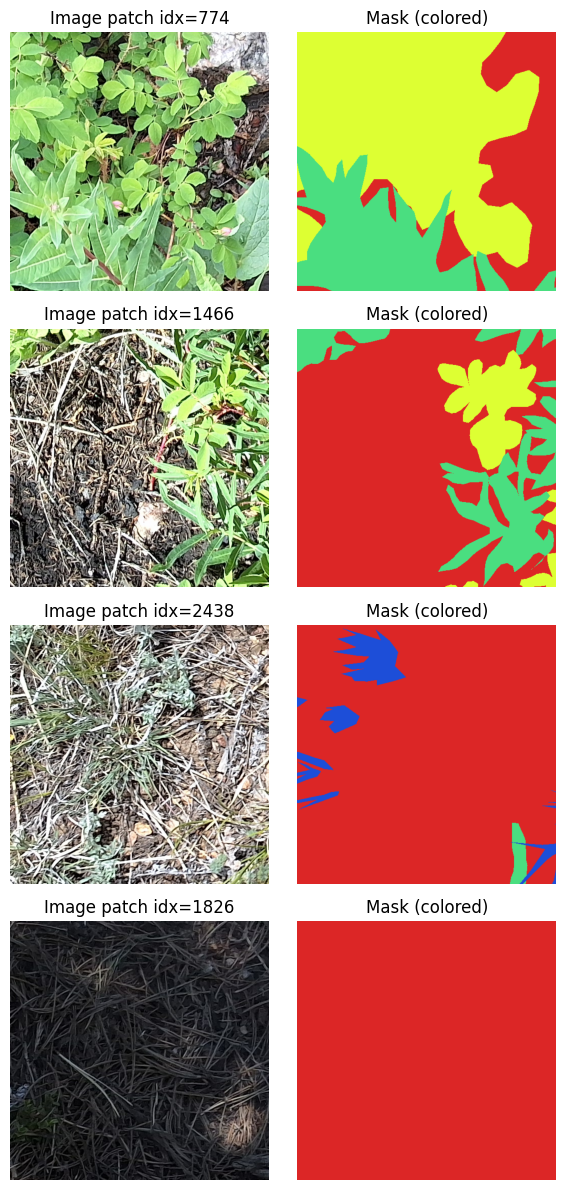

In [16]:
visualize_patches(train_patches, color_map, num_samples=4)

In [45]:
loader = DataLoader(train_patches, batch_size=1, shuffle=False, num_workers=0)
for i, (im, ms, _) in enumerate(loader):
    if im.shape[-1] != 512 or im.shape[-2] != 512 or ms.shape[-1] != 512 or ms.shape[-2] != 512:
        print("Bad sample at i=", i, im.shape, ms.shape)
        break
print("Checked a bunch of samples OK")

Checked a bunch of samples OK


In [ ]:
import numpy as np
import torch
from collections import defaultdict

def compute_class_frequencies(dataset, num_classes):
    pixel_counts = np.zeros(num_classes, dtype=np.int64)

    for i in range(len(dataset)):
        sample = dataset[i]  # sample is a list of (image_patch, mask_patch)
        for _, mask in sample:
            if isinstance(mask, torch.Tensor):
                mask_np = mask.cpu().numpy()
            else:
                mask_np = np.array(mask)

            for cls in range(num_classes):
                pixel_counts[cls] += np.sum(mask_np == cls)

    total_pixels = np.sum(pixel_counts)
    frequencies = pixel_counts / total_pixels
    return pixel_counts, frequencies


num_classes = 4
pixel_counts, class_freqs = compute_class_frequencies(train_dataset, num_classes)

print("Pixel Counts:", pixel_counts)
print("Class Frequencies:", class_freqs)

In [46]:
class_freqs = np.array([0.75737137, 0.07248701, 0.09868436, 0.07145727])

Smooth freqs to avoid massive boost

In [47]:
weights = torch.tensor(np.log(1.0 / class_freqs + 1), dtype=torch.float32)
print(weights)

tensor([0.8417, 2.6943, 2.4099, 2.7077])


In [48]:
import torch.nn.functional as F

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        """
        Tversky Loss:
          alpha controls penalty for false positives.
          beta controls penalty for false negatives.
        """
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs: [N, C, H, W] logits from the model
        # targets: [N, H, W] ground truth labels
        # Convert logits to probabilities
        inputs = F.softmax(inputs, dim=1)

        # One-hot encode targets to shape [N, C, H, W]
        num_classes = inputs.shape[1]
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0,3,1,2).float()

        # Flatten the tensors per class: shape [N, C, H*W]
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        targets_one_hot = targets_one_hot.view(targets_one_hot.size(0), targets_one_hot.size(1), -1)

        # Compute per-class true positives, false positives and false negatives
        TP = (inputs * targets_one_hot).sum(dim=2)
        FP = (inputs * (1 - targets_one_hot)).sum(dim=2)
        FN = ((1 - inputs) * targets_one_hot).sum(dim=2)

        # Compute Tversky index for each class and for each sample
        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        # The loss is 1 - mean(Tversky index) over classes and batch
        loss = 1 - tversky.mean()
        return loss

In [49]:
def safe_collate(batch):
    # batch: list of (img_tensor, mask_tensor)
    imgs, masks = zip(*batch)                      # tuples of tensors
    # Make sure each is contiguous and owns storage
    imgs  = [t.contiguous() for t in imgs]
    masks = [t.contiguous() for t in masks]
    return torch.stack(imgs, dim=0), torch.stack(masks, dim=0)

In [50]:
import math
import numpy as np
from torch.utils.data import Sampler

class ImageGroupedBatchSampler(Sampler[list[int]]):
    """
    Yields lists of dataset indices where each list contains patches from a single image_id,
    chunked by `batch_size`.

    Works with PatchDataset that has:
      - grouped_patch_indices: dict[image_id] -> list[int] (patch indices)
    """
    def __init__(
        self,
        patch_dataset,
        batch_size: int,
        shuffle_images: bool = True,
        shuffle_patches: bool = True,
        drop_last: bool = False,
        seed: int | None = None,
    ):
        self.ds = patch_dataset
        self.batch_size = int(batch_size)
        self.shuffle_images = shuffle_images
        self.shuffle_patches = shuffle_patches
        self.drop_last = drop_last
        self.seed = seed
        self.image_ids = list(self.ds.grouped_patch_indices.keys())

    def __iter__(self):
        rng = np.random.default_rng(self.seed)

        image_ids = self.image_ids.copy()
        if self.shuffle_images:
            rng.shuffle(image_ids)

        for img_id in image_ids:
            idxs = self.ds.grouped_patch_indices[img_id].copy()
            if self.shuffle_patches:
                rng.shuffle(idxs)

            # yield contiguous chunks for this image
            bs = self.batch_size
            n = len(idxs)
            full = (n // bs) * bs
            # full batches
            for i in range(0, full, bs):
                yield idxs[i:i+bs]
            # tail
            rem = n - full
            if rem and not self.drop_last:
                yield idxs[full:]
            # if drop_last=True, we skip the tail

    def __len__(self):
        # number of batches across all images
        bs = self.batch_size
        total = 0
        for img_id in self.image_ids:
            n = len(self.ds.grouped_patch_indices[img_id])
            if self.drop_last:
                total += n // bs
            else:
                total += math.ceil(n / bs)
        return total


In [51]:
def simple_collate(batch):
    # batch: list of (img_uint8[3,H,W], msk_long[H,W], image_id)
    imgs   = torch.stack([b[0] for b in batch], dim=0)
    masks  = torch.stack([b[1] for b in batch], dim=0)
    img_ids= torch.tensor([b[2] for b in batch], dtype=torch.long)
    return imgs, masks, img_ids

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU")
    torch.backends.cudnn.benchmark = True  # fixed input sizes -> faster
use_cuda = (device.type == "cuda")
amp_dtype = torch.float16
scaler = GradScaler(enabled=use_cuda) 

unet_model = unet_model.to(device)

# <-- make sure weights are float and on device


dice = smp.losses.DiceLoss(
    mode='multiclass',
    from_logits=True,
    ignore_index=None,
    classes=[1, 2, 3],   # <-- exclude background (0)
    smooth=1.0, eps=1e-7
)
ce   = nn.CrossEntropyLoss(weight=weights.float().to(device))

LAMBDA_DICE = 0.5 
def criterion(logits, targets):
    return ce(logits, targets) + LAMBDA_DICE * dice(logits, targets)

optimizer = optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

batch_sampler = ImageGroupedBatchSampler(
    train_patches,
    batch_size=8,
    shuffle_images=True,
    shuffle_patches=True,
    drop_last=False,
    seed=42,
)

train_loader = DataLoader(
    train_patches, batch_sampler=batch_sampler,
    num_workers=4, pin_memory=True,
    persistent_workers=False, prefetch_factor=2, collate_fn=simple_collate,
    
)

val_batch_sampler = ImageGroupedBatchSampler(
    val_patches, batch_size=8, shuffle_images=False, shuffle_patches=False
)

val_loader = DataLoader(
    val_patches, batch_sampler=val_batch_sampler,
    num_workers=4, pin_memory=True,
    persistent_workers=False, prefetch_factor=2, collate_fn=simple_collate,
   
)

GPU


In [54]:
dl = DataLoader(train_patches, batch_size=8, num_workers=0)
for i, (x,y, _) in enumerate(dl):
    if i == 10:
        break
print("CPU single-worker OK:", x.shape, x.dtype, y.shape, y.dtype)

# then with workers
dlw = DataLoader(train_patches, batch_size=8, num_workers=2, prefetch_factor=2, pin_memory=True)
for i, (x,y, _) in enumerate(dlw):
    if i == 10:
        break
print("Multi-worker OK")

CPU single-worker OK: torch.Size([8, 3, 512, 512]) torch.uint8 torch.Size([8, 512, 512]) torch.int64
Multi-worker OK


In [55]:
import os, psutil, gc
def rss_gb():
    return psutil.Process(os.getpid()).memory_info().rss / 1024**3
print(f"RSS now: {rss_gb():.2f} GB")

RSS now: 2.21 GB


In [23]:
imgs, masks, _ = next(iter(train_loader))
print(imgs.shape, imgs.dtype, masks.shape, masks.dtype)  # [B,3,512,512] torch.uint8; [B,512,512] torch.int64


torch.Size([8, 3, 512, 512]) torch.uint8 torch.Size([8, 512, 512]) torch.int64


In [56]:
del loader, imgs, masks
import gc; gc.collect()

NameError: name 'imgs' is not defined

In [57]:
for imgs, masks, img_ids in train_loader:
    # All patches in this batch should come from the same image_id (often one or a few ids if
    # an image has more than batch_size patches).
    print("unique image_ids in batch:", img_ids.unique().tolist())
    break


unique image_ids in batch: [59]


In [61]:


best_val_loss = float('inf')
patience = 5
early_stop_counter = 0
best_model_path = "best_model.pth"

num_epochs = 25


for epoch in range(num_epochs):
    train_loss, train_acc, train_miou, train_iou = train_unet(
        unet_model, train_loader, optimizer, criterion, device,
        num_classes=4, scaler=scaler, amp_dtype=amp_dtype, amp_enabled=True
    )
    val_loss, val_acc, val_miou, val_iou = validate_unet(   # add AMP to val too
        unet_model, val_loader, criterion, device, num_classes=4,
        amp_dtype=amp_dtype, amp_enabled=True
    )

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train => Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, mIoU: {train_miou:.4f}")
    print(f"  Val   => Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, mIoU: {val_miou:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(unet_model.state_dict(), best_model_path)
        print("  ✅ Validation loss improved, model saved.")
    else:
        early_stop_counter += 1
        print(f"  ⚠️ No improvement. Early stop counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

Validating: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


Epoch 1/25
  Train => Loss: 1.2215, Acc: 75.10%, mIoU: 0.3036
  Val   => Loss: 0.9681, Acc: 74.54%, mIoU: 0.3277
  ✅ Validation loss improved, model saved.


Validating: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 2/25
  Train => Loss: 1.1559, Acc: 76.48%, mIoU: 0.3231
  Val   => Loss: 0.9159, Acc: 78.03%, mIoU: 0.3408
  ✅ Validation loss improved, model saved.


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


Epoch 3/25
  Train => Loss: 1.1116, Acc: 77.42%, mIoU: 0.3328
  Val   => Loss: 0.9467, Acc: 77.30%, mIoU: 0.3351
  ⚠️ No improvement. Early stop counter: 1/5


Validating: 100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 4/25
  Train => Loss: 1.0923, Acc: 77.59%, mIoU: 0.3384
  Val   => Loss: 0.8663, Acc: 78.85%, mIoU: 0.3599
  ✅ Validation loss improved, model saved.


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


Epoch 5/25
  Train => Loss: 1.0522, Acc: 78.07%, mIoU: 0.3529
  Val   => Loss: 0.8724, Acc: 79.88%, mIoU: 0.3719
  ⚠️ No improvement. Early stop counter: 1/5


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


Epoch 6/25
  Train => Loss: 1.0262, Acc: 78.76%, mIoU: 0.3824
  Val   => Loss: 0.8526, Acc: 79.60%, mIoU: 0.3919
  ✅ Validation loss improved, model saved.


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.50it/s]


Epoch 7/25
  Train => Loss: 0.9855, Acc: 79.65%, mIoU: 0.4099
  Val   => Loss: 0.8228, Acc: 82.10%, mIoU: 0.4459
  ✅ Validation loss improved, model saved.


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.87it/s]


Epoch 8/25
  Train => Loss: 0.9540, Acc: 80.67%, mIoU: 0.4377
  Val   => Loss: 0.8247, Acc: 82.60%, mIoU: 0.4534
  ⚠️ No improvement. Early stop counter: 1/5


Validating: 100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


Epoch 9/25
  Train => Loss: 0.9160, Acc: 81.38%, mIoU: 0.4575
  Val   => Loss: 0.8220, Acc: 83.30%, mIoU: 0.4506
  ✅ Validation loss improved, model saved.


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


Epoch 10/25
  Train => Loss: 0.8675, Acc: 82.67%, mIoU: 0.4910
  Val   => Loss: 0.8511, Acc: 82.47%, mIoU: 0.4153
  ⚠️ No improvement. Early stop counter: 1/5


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


Epoch 11/25
  Train => Loss: 0.8290, Acc: 83.25%, mIoU: 0.5099
  Val   => Loss: 0.8878, Acc: 82.87%, mIoU: 0.4147
  ⚠️ No improvement. Early stop counter: 2/5


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.82it/s]


Epoch 12/25
  Train => Loss: 0.7777, Acc: 84.00%, mIoU: 0.5291
  Val   => Loss: 0.9436, Acc: 81.48%, mIoU: 0.3831
  ⚠️ No improvement. Early stop counter: 3/5


Validating: 100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


Epoch 13/25
  Train => Loss: 0.7463, Acc: 84.37%, mIoU: 0.5418
  Val   => Loss: 0.9700, Acc: 81.20%, mIoU: 0.3812
  ⚠️ No improvement. Early stop counter: 4/5


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


Epoch 14/25
  Train => Loss: 0.6804, Acc: 85.26%, mIoU: 0.5699
  Val   => Loss: 0.7828, Acc: 83.47%, mIoU: 0.4757
  ✅ Validation loss improved, model saved.


Validating: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 15/25
  Train => Loss: 0.6432, Acc: 86.06%, mIoU: 0.5898
  Val   => Loss: 0.7840, Acc: 83.77%, mIoU: 0.4797
  ⚠️ No improvement. Early stop counter: 1/5


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


Epoch 16/25
  Train => Loss: 0.6213, Acc: 86.52%, mIoU: 0.6028
  Val   => Loss: 0.7832, Acc: 83.95%, mIoU: 0.4834
  ⚠️ No improvement. Early stop counter: 2/5


Validating: 100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Epoch 17/25
  Train => Loss: 0.6029, Acc: 86.89%, mIoU: 0.6144
  Val   => Loss: 0.7860, Acc: 84.11%, mIoU: 0.4853
  ⚠️ No improvement. Early stop counter: 3/5


Validating: 100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


Epoch 18/25
  Train => Loss: 0.5849, Acc: 87.27%, mIoU: 0.6259
  Val   => Loss: 0.7943, Acc: 84.19%, mIoU: 0.4852
  ⚠️ No improvement. Early stop counter: 4/5


Validating: 100%|██████████| 100/100 [00:12<00:00,  7.91it/s]

Epoch 19/25
  Train => Loss: 0.5709, Acc: 87.56%, mIoU: 0.6332
  Val   => Loss: 0.8410, Acc: 83.68%, mIoU: 0.4595
  ⚠️ No improvement. Early stop counter: 5/5
⏹️ Early stopping triggered.


In [62]:
unet_model.load_state_dict(torch.load("best_model.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = unet_model.to(device)

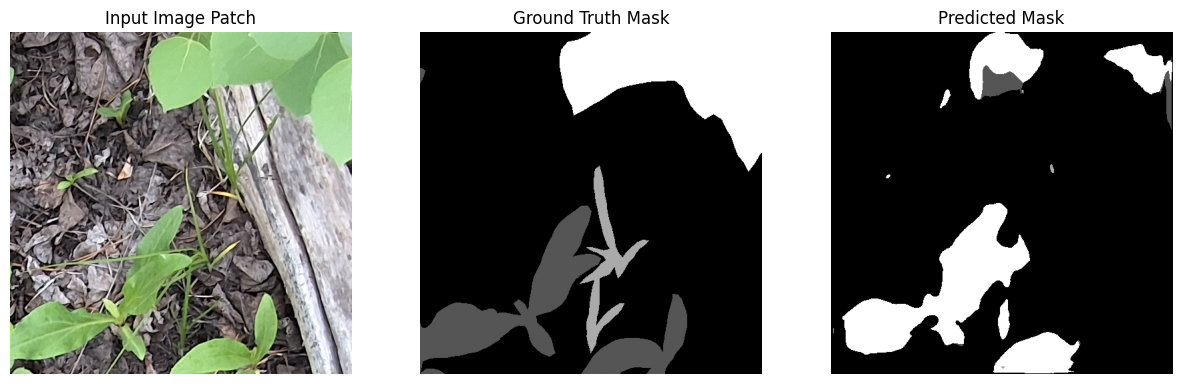

In [63]:
# Select a sample from your validation dataset (or a sample patch)
sample = val_dataset[7]  # get the first sample (a list of patches)
# Choose one patch, for instance, the first patch in the sample
img_patch, mask_patch = sample[5]

# Convert to tensor if needed and add batch dimension
if not isinstance(img_patch, torch.Tensor):
    img_patch = transforms.ToTensor()(img_patch)
img_patch = img_patch.unsqueeze(0).to(device)

# Run the model forward pass
unet_model.eval()
with torch.no_grad():
    output = unet_model(img_patch)  # assume UNet returns logits

# Get predicted class for every pixel
pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# Visualize input, ground truth, and predicted mask
# Convert image patch to numpy for display (if normalized, you may need to un-normalize)
img_np = img_patch.squeeze(0).cpu().permute(1,2,0).numpy()
mask_np = mask_patch.cpu().numpy()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title("Input Image Patch")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask_np, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

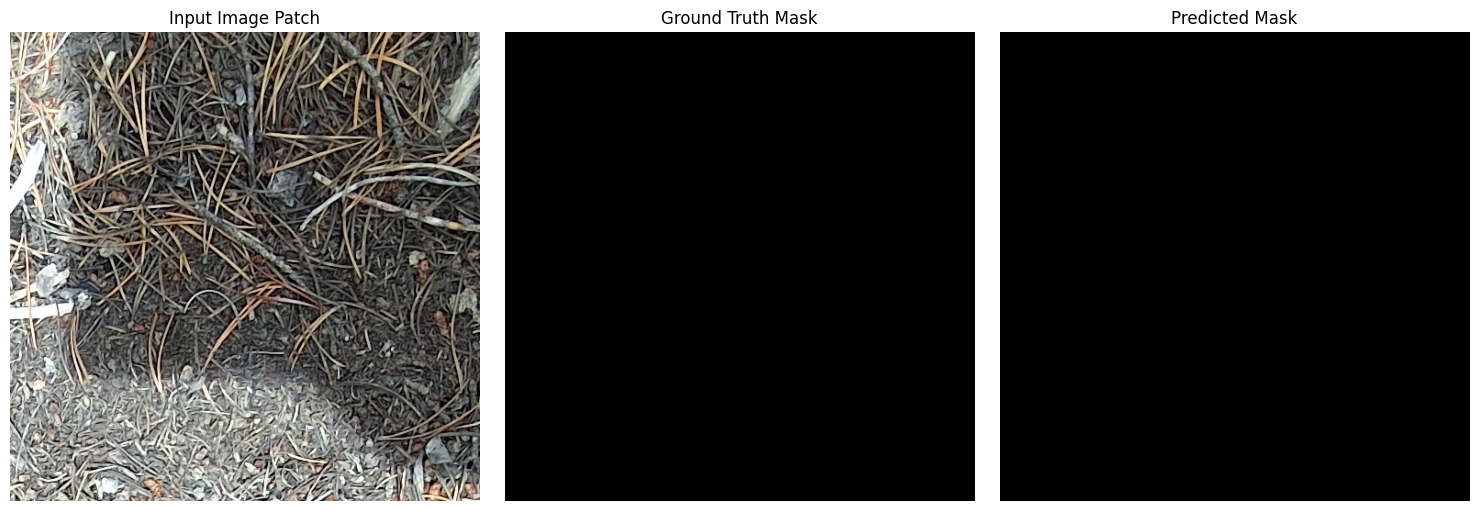

In [64]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Class color map (index to RGB)
index_to_color = {
    0: (0, 0, 0),          # Background (and Litter)
    1: (74, 222, 128),     # Forb
    2: (96, 165, 250),     # Short Graminoid (also includes Tall Graminoid)
    3: (221, 255, 51),     # Woody
}

def decode_segmap(mask):
    """
    Converts class indices to RGB image using index_to_color.
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_idx, rgb in index_to_color.items():
        color_mask[mask == class_idx] = rgb

    return color_mask

# --- Sample one patch from validation set
sample = val_dataset[8]  # One image with patches
img_patch, mask_patch = sample[5]

# Convert image patch to tensor and send to device
if not isinstance(img_patch, torch.Tensor):
    img_patch = transforms.ToTensor()(img_patch)
img_patch = img_patch.unsqueeze(0).to(device)

# Forward pass through the model
unet_model.eval()
with torch.no_grad():
    output = unet_model(img_patch)

# Predicted class mask
pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# Convert tensors for display
img_np = img_patch.squeeze(0).cpu().permute(1,2,0).numpy()
mask_np = mask_patch.cpu().numpy()

# Map ground truth and prediction to RGB colors
gt_colored = decode_segmap(mask_np)
pred_colored = decode_segmap(pred_mask)

# --- Plot the results
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title("Input Image Patch")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(gt_colored)
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_colored)
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [65]:
def create_gaussian_weight_mask(patch_size, sigma_scale=1./8, device='cpu'):
    """
    Create a 2D Gaussian weight mask normalized to 1.
    """
    H, W = patch_size
    sigma_x = W * sigma_scale
    sigma_y = H * sigma_scale

    x = torch.linspace(-1.0, 1.0, W, device=device)
    y = torch.linspace(-1.0, 1.0, H, device=device)

    X,Y = torch.meshgrid(x,y, indexing='xy')

    gauss = torch.exp(-0.5 * ((X / sigma_x) ** 2 + (Y / sigma_y) ** 2))
    gauss /= gauss.max()
    return gauss # shape H, W

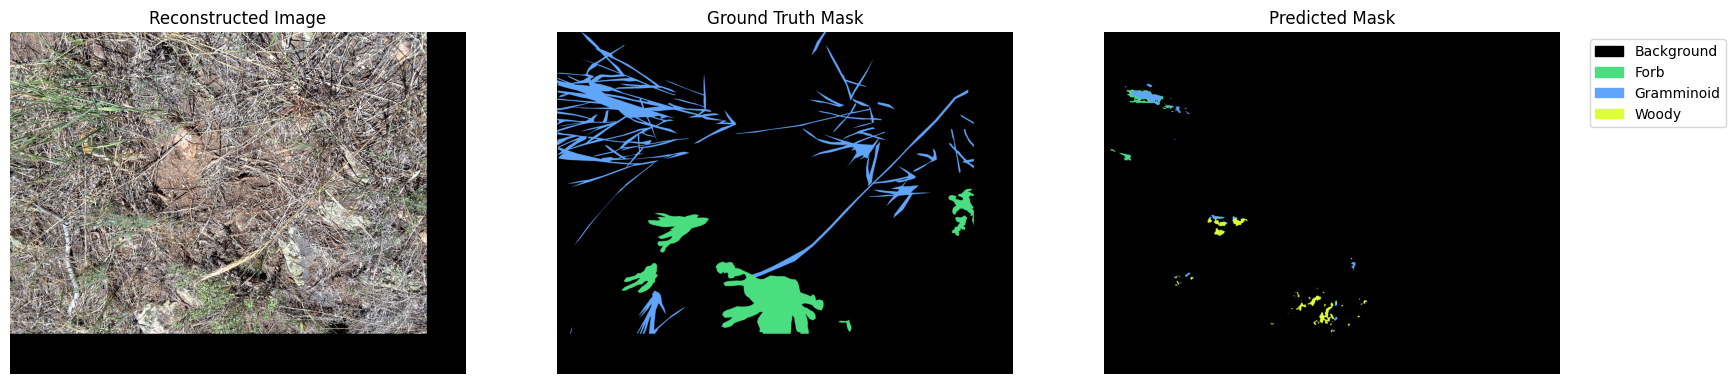

In [67]:
import matplotlib.patches as mpatches
patch_size = 512
overlap = 100
stride = patch_size - overlap
full_h, full_w = 2448, 3264  # Full image size

gaussian_mask = create_gaussian_weight_mask((patch_size, patch_size), device=device)
gaussian_mask = gaussian_mask.cpu().numpy()
# Get patch list from dataset
sample = val_dataset[0]  # sample = list of (img_patch, mask_patch) pairs

# Initialize containers
full_image = np.zeros((full_h, full_w, 3), dtype=np.float32)
full_mask = np.zeros((full_h, full_w), dtype=np.float32)
pred_mask = np.zeros((full_h, full_w), dtype=np.float32)

# Overlap counter for averaging
image_count = np.zeros((full_h, full_w, 1), dtype=np.float32)
mask_count = np.zeros((full_h, full_w), dtype=np.float32)
pred_count = np.zeros((full_h, full_w), dtype=np.float32)

# Loop over patches
patch_idx = 0
for y in range(0, full_h - patch_size + 1, stride):
    for x in range(0, full_w - patch_size + 1, stride):
        img_patch, mask_patch = sample[patch_idx]

        
        if not isinstance(img_patch, torch.Tensor):
            img_patch_tensor = transforms.ToTensor()(img_patch)
        else:
            img_patch_tensor = img_patch

        img_patch_tensor = img_patch_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = unet_model(img_patch_tensor)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Convert image patch to numpy
        img_np = img_patch_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

        mask_np = mask_patch.cpu().numpy()

        weighted_pred = pred * gaussian_mask


        # Add to full image/mask
        full_image[y:y+patch_size, x:x+patch_size] += img_np
        full_mask[y:y+patch_size, x:x+patch_size] += mask_np
        pred_mask[y:y+patch_size, x:x+patch_size] += pred

        image_count[y:y+patch_size, x:x+patch_size] += 1
        mask_count[y:y+patch_size, x:x+patch_size] += 1
        pred_count[y:y+patch_size, x:x+patch_size] += 1

        patch_idx += 1

# Average overlapping areas
full_image = np.divide(full_image, image_count, out=np.zeros_like(full_image), where=image_count!=0)
full_mask = np.divide(full_mask, mask_count, out=np.zeros_like(full_mask), where=mask_count!=0)
pred_mask = np.divide(pred_mask, pred_count, out=np.zeros_like(pred_mask), where=pred_count!=0)

# Round masks to nearest class integer
full_mask = full_mask.round().astype(np.uint8)
pred_mask = pred_mask.round().astype(np.uint8)

full_mask_color = decode_segmap(full_mask)
pred_mask_color = decode_segmap(pred_mask)

# --- Visualization ---
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.imshow(full_image)
plt.title("Reconstructed Image")
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(full_mask_color)
plt.title("Ground Truth Mask")
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(pred_mask_color)
plt.title("Predicted Mask")
plt.axis('off')

legend_patches = [mpatches.Patch(color=[r/255, g/255, b/255], label=label) for (r,g,b), label in name_map.items()]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [27]:
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def predict_mask_from_image_path(image_path, unet_model, patch_size=512, overlap=100, device='cuda'):
    # Load and convert image
    image = Image.open(image_path).convert('RGB')
    full_w, full_h = image.size
    stride = patch_size - overlap

    # Prepare Gaussian mask
    gaussian_mask = create_gaussian_weight_mask((patch_size, patch_size), device=device).cpu().numpy()

    # Initialize containers
    full_image = np.zeros((full_h, full_w, 3), dtype=np.float32)
    pred_mask = np.zeros((full_h, full_w), dtype=np.float32)
    image_count = np.zeros((full_h, full_w, 1), dtype=np.float32)
    pred_count = np.zeros((full_h, full_w), dtype=np.float32)

    to_tensor = transforms.ToTensor()

    # Extract and process patches
    for y in range(0, full_h - patch_size + 1, stride):
        for x in range(0, full_w - patch_size + 1, stride):
            patch = image.crop((x, y, x + patch_size, y + patch_size))
            img_tensor = to_tensor(patch).unsqueeze(0).to(device)

            with torch.no_grad():
                output = unet_model(img_tensor)
                pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            pred_weighted = pred * gaussian_mask

            # Optional: also visualize reconstructed RGB image
            patch_np = img_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
            full_image[y:y+patch_size, x:x+patch_size] += patch_np
            image_count[y:y+patch_size, x:x+patch_size] += 1

            pred_mask[y:y+patch_size, x:x+patch_size] += pred_weighted
            pred_count[y:y+patch_size, x:x+patch_size] += gaussian_mask

    # Normalize and convert
    full_image = np.divide(full_image, image_count, out=np.zeros_like(full_image), where=image_count!=0)
    pred_mask = np.divide(pred_mask, pred_count, out=np.zeros_like(pred_mask), where=pred_count!=0)
    pred_mask = pred_mask.round().astype(np.uint8)

    pred_mask_color = decode_segmap(pred_mask)

    # --- Visualization ---
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(full_image)
    plt.title("Reconstructed Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask_color)
    plt.title("Predicted Mask")
    plt.axis('off')

    legend_patches = [mpatches.Patch(color=[r/255, g/255, b/255], label=label) for (r, g, b), label in name_map.items()]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    return pred_mask


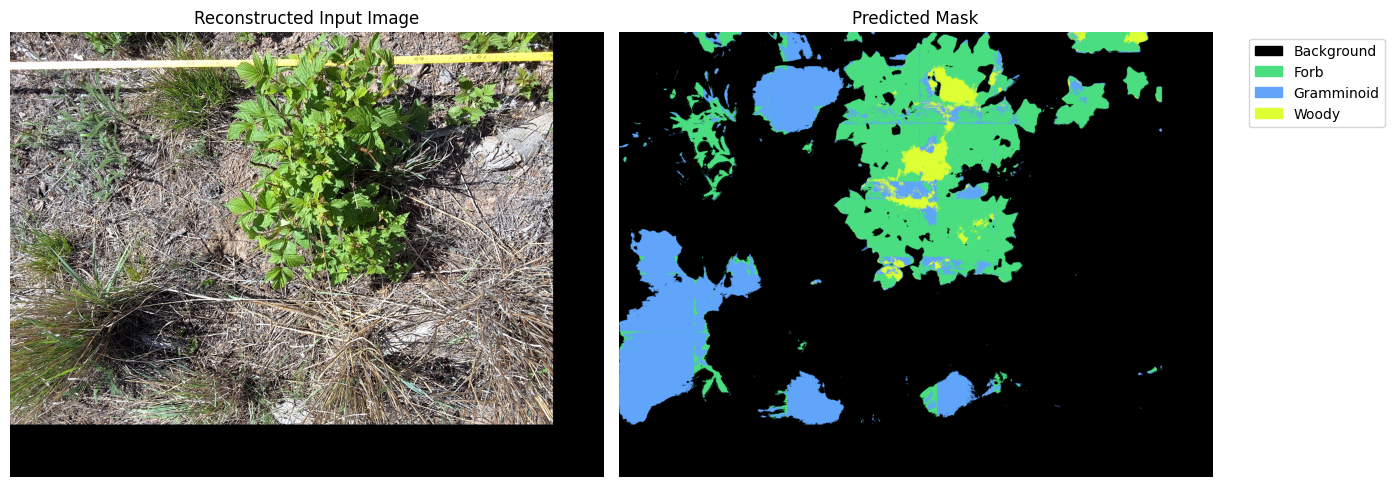

In [28]:
image_path = '/home/nels/TeamVida/Test/1718209825924.jpg'
pred_mask = predict_mask_from_image_path(image_path, unet_model, patch_size=512, overlap=100, device=device)

Image 20 is good (train)

Image 3, 5, 8 9, 10, 12 (Val)

Problems: 7

Super promising: 4

Very busy image: 3

Mislabeled patches: 1

Rock problem: 13

In [42]:
torch.save(unet_model.state_dict(), 'unet_model_2.pth')

In [3]:
import torch
import segmentation_models_pytorch as smp

# Build the same model architecture
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,   # use None if you’re loading your own weights
    in_channels=3,
    classes=4
)

# Load your state_dict
ckpt = torch.load("Best59Model.pth", map_location="cpu")
model.load_state_dict(ckpt)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [4]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "unet_smp_scripted.pt")

In [6]:
ts_model = torch.jit.load("unet_smp_scripted.pt")  # or scripted
ts_model.eval()

x = torch.randn(1, 3, 512, 512)
with torch.no_grad():
    y = ts_model(x)
print(y.shape)  # should be [1, 4, H, W]

torch.Size([1, 4, 512, 512])
